In [1]:
%%bash
nvidia-smi

Tue Jun  9 16:16:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import gc
import os
import random
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics, preprocessing
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

In [0]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [0]:
""" 
TF-Keras SWA: callback utility for performing stochastic weight averaging (SWA).
from https://github.com/simon-larsson/keras-swa
"""

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import BatchNormalization

class SWA(Callback):
    """ Stochastic Weight Averging.
    # Paper
        title: Averaging Weights Leads to Wider Optima and Better Generalization
        link: https://arxiv.org/abs/1803.05407
    # Arguments
        start_epoch:   integer, epoch when swa should start.
        lr_schedule:   string, type of learning rate schedule.
        swa_lr:        float, learning rate for swa sampling.
        swa_lr2:       float, upper bound of cyclic learning rate.
        swa_freq:      integer, length of learning rate cycle.
        verbose:       integer, verbosity mode, 0 or 1.
    """
    def __init__(self,
                 start_epoch,
                 lr_schedule='manual',
                 swa_lr='auto',
                 swa_lr2='auto',
                 swa_freq=1,
                 verbose=0):
                 
        super(SWA, self).__init__()
        self.start_epoch = start_epoch - 1
        self.lr_schedule = lr_schedule
        self.swa_lr = swa_lr
        self.swa_lr2 = swa_lr2
        self.swa_freq = swa_freq
        self.verbose = verbose

        if start_epoch < 2:
            raise ValueError('"swa_start" attribute cannot be lower than 2.')

        schedules = ['manual', 'constant', 'cyclic']

        if self.lr_schedule not in schedules:
            raise ValueError('"{}" is not a valid learning rate schedule' \
                             .format(self.lr_schedule))

        if self.lr_schedule == 'cyclic' and self.swa_freq < 2:
            raise ValueError('"swa_freq" must be higher than 1 for cyclic schedule.')

        if self.swa_lr == 'auto' and self.swa_lr2 != 'auto':
            raise ValueError('"swa_lr2" cannot be manually set if "swa_lr" is automatic.') 
            
        if self.lr_schedule == 'cyclic' and self.swa_lr != 'auto' \
           and self.swa_lr2 != 'auto' and self.swa_lr > self.swa_lr2:
            raise ValueError('"swa_lr" must be lower than "swa_lr2".')

    def on_train_begin(self, logs=None):

        self.epochs = self.params.get('epochs')

        if self.start_epoch >= self.epochs - 1:
            raise ValueError('"swa_start" attribute must be lower than "epochs".')

        self.init_lr = K.eval(self.model.optimizer.lr)

        # automatic swa_lr
        if self.swa_lr == 'auto':
            self.swa_lr = 0.1*self.init_lr
        
        if self.init_lr < self.swa_lr:
            raise ValueError('"swa_lr" must be lower than rate set in optimizer.')

        # automatic swa_lr2 between initial lr and swa_lr   
        if self.lr_schedule == 'cyclic' and self.swa_lr2 == 'auto':
            self.swa_lr2 = self.swa_lr + (self.init_lr - self.swa_lr)*0.25

        self._check_batch_norm()

    def on_epoch_begin(self, epoch, logs=None):

        self.current_epoch = epoch
        self._scheduler(epoch)

        # constant schedule is updated epoch-wise
        if self.lr_schedule == 'constant' or self.is_batch_norm_epoch:
            self._update_lr(epoch)

        if self.is_swa_start_epoch:
            self.swa_weights = self.model.get_weights()

            if self.verbose > 0:
                print('\nEpoch %05d: starting stochastic weight averaging'
                      % (epoch + 1))

        if self.is_batch_norm_epoch:
            self._set_swa_weights(epoch)

            if self.verbose > 0:
                print('\nEpoch %05d: reinitializing batch normalization layers'
                      % (epoch + 1))

            self._reset_batch_norm()

            if self.verbose > 0:
                print('\nEpoch %05d: running forward pass to adjust batch normalization'
                      % (epoch + 1))

    def on_batch_begin(self, batch, logs=None):

        # update lr each batch for cyclic lr schedule
        if self.lr_schedule == 'cyclic':
            self._update_lr(self.current_epoch, batch)

        if self.is_batch_norm_epoch:

            batch_size = self.params['samples']
            momentum = batch_size / (batch*batch_size + batch_size)

            for layer in self.batch_norm_layers:
                layer.momentum = momentum

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        logs['lr'] = K.eval(self.model.optimizer.lr)
        for k, v in logs.items():
            if k == 'lr':
                self.model.history.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):

        if self.is_swa_start_epoch:
            self.swa_start_epoch = epoch

        if self.is_swa_epoch and not self.is_batch_norm_epoch:
            self.swa_weights = self._average_weights(epoch)

    def on_train_end(self, logs=None):

        if not self.has_batch_norm:
            self._set_swa_weights(self.epochs)
        else:
            self._restore_batch_norm()

    def _scheduler(self, epoch):

        swa_epoch = (epoch - self.start_epoch)

        self.is_swa_epoch = epoch >= self.start_epoch and swa_epoch % self.swa_freq == 0
        self.is_swa_start_epoch = epoch == self.start_epoch
        self.is_batch_norm_epoch = epoch == self.epochs - 1 and self.has_batch_norm

    def _average_weights(self, epoch):

        return [(swa_w * (epoch - self.start_epoch) + w)
                / ((epoch - self.start_epoch) + 1)
                for swa_w, w in zip(self.swa_weights, self.model.get_weights())]

    def _update_lr(self, epoch, batch=None):

        if self.is_batch_norm_epoch:
            lr = 0
            K.set_value(self.model.optimizer.lr, lr)
        elif self.lr_schedule == 'constant':
            lr = self._constant_schedule(epoch)
            K.set_value(self.model.optimizer.lr, lr)
        elif self.lr_schedule == 'cyclic':
            lr = self._cyclic_schedule(epoch, batch)
            K.set_value(self.model.optimizer.lr, lr)

    def _constant_schedule(self, epoch):

        t = epoch / self.start_epoch
        lr_ratio = self.swa_lr / self.init_lr
        if t <= 0.5:
            factor = 1.0
        elif t <= 0.9:
            factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
        else:
            factor = lr_ratio
        return self.init_lr * factor

    def _cyclic_schedule(self, epoch, batch):
        """ Designed after Section 3.1 of Averaging Weights Leads to
        Wider Optima and Better Generalization(https://arxiv.org/abs/1803.05407)
        """
        # steps are mini-batches per epoch, equal to training_samples / batch_size
        steps = self.params.get('steps')
        
        #occasionally steps parameter will not be set. We then calculate it ourselves
        if steps == None:
            steps = self.params['samples'] // self.params['batch_size']
        
        swa_epoch = (epoch - self.start_epoch) % self.swa_freq
        cycle_length = self.swa_freq * steps

        # batch 0 indexed, so need to add 1
        i = (swa_epoch * steps) + (batch + 1)
        if epoch >= self.start_epoch:
            t = (((i-1) % cycle_length) + 1)/cycle_length
            return (1-t)*self.swa_lr2 + t*self.swa_lr
        else:
            return self._constant_schedule(epoch)

    def _set_swa_weights(self, epoch):

        self.model.set_weights(self.swa_weights)

        if self.verbose > 0:
            print('\nEpoch %05d: final model weights set to stochastic weight average'
                  % (epoch + 1))

    def _check_batch_norm(self):

        self.batch_norm_momentums = []
        self.batch_norm_layers = []
        self.has_batch_norm = False
        self.running_bn_epoch = False

        for layer in self.model.layers:
            if issubclass(layer.__class__, BatchNormalization):
                self.has_batch_norm = True
                self.batch_norm_momentums.append(layer.momentum)
                self.batch_norm_layers.append(layer)

        if self.verbose > 0 and self.has_batch_norm:
            print('Model uses batch normalization. SWA will require last epoch '
                  'to be a forward pass and will run with no learning rate')

    def _reset_batch_norm(self):

        for layer in self.batch_norm_layers:

            # to get properly initialized moving mean and moving variance weights
            # we initialize a new batch norm layer from the config of the existing
            # layer, build that layer, retrieve its reinitialized moving mean and
            # moving var weights and then delete the layer
            bn_config = layer.get_config()
            new_batch_norm = BatchNormalization(**bn_config)
            new_batch_norm.build(layer.input_shape)
            new_moving_mean, new_moving_var = new_batch_norm.get_weights()[-2:]
            # get rid of the new_batch_norm layer
            del new_batch_norm
            # get the trained gamma and beta from the current batch norm layer
            trained_weights = layer.get_weights()
            new_weights = []
            # get gamma if exists
            if bn_config['scale']:
                new_weights.append(trained_weights.pop(0))
            # get beta if exists
            if bn_config['center']:
                new_weights.append(trained_weights.pop(0))
            new_weights += [new_moving_mean, new_moving_var]
            # set weights to trained gamma and beta, reinitialized mean and variance
            layer.set_weights(new_weights)

    def _restore_batch_norm(self):

        for layer, momentum in zip(self.batch_norm_layers, self.batch_norm_momentums):
            layer.momentum = momentum

In [0]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)

    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [0]:
def read_data():
    train = pd.read_csv('../input/train_spec.csv')
    test  = pd.read_csv('../input/test_spec.csv')
    sub  = pd.read_csv('../input/atmaCup5__sample_submission.csv')
    return train, test, sub

def Scaling(train,test,features):
    train_input_mean = train[features].mean(axis=1)
    train_input_sigma = train[features].std(axis=1)
    test_input_mean = test[features].mean(axis=1)
    test_input_sigma = test[features].std(axis=1)
    train[features]= train[features].sub(train_input_mean, axis=0).div(train_input_sigma, axis=0)
    test[features] = test[features].sub(test_input_mean, axis=0).div(test_input_sigma, axis=0)
    return train, test

def Scaling_single(df, features):
    df_input_mean = df[features].mean(axis=1)
    df_input_sigma = df[features].std(axis=1)
    df[features]= df[features].sub(df_input_mean, axis=0).div(df_input_sigma, axis=0)
    return df

In [0]:
def lr_schedule(epoch):
    return LR

In [0]:
def Classifier():
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (512, 1))

    x = wave_block(inp, 16, 5, 8)
    x = wave_block(x, 32, 5, 12)
    x = wave_block(x, 64, 5, 4)
    x = wave_block(x, 128, 5, 1)

    x_max = GlobalMaxPooling1D()(x)
    x_mean = GlobalAveragePooling1D()(x)
    x = Concatenate()([x_max, x_mean])
    x = Dropout(0.2)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    out = Dense(1, activation = 'sigmoid', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr=LR)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[pr_metric])
    return model

In [0]:
def run_cv_model_by_batch(train, test, splits, feats, sample_submission, nn_epochs, nn_batch_size):
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    oof = np.load("../output/oof.0.86263.npy")
    sub = np.load("../output/preds.0.86263.npy")    
    pused_test = test.copy()
    pused_test['target'] = sub
    pused_test = pused_test[(sub >= 0.99) | (sub <= 0.01)].copy().reset_index(drop=True)
    pused_test.loc[ pused_test['target']>=0.5, 'target' ] = 1
    pused_test.loc[ pused_test['target']<0.5, 'target' ] = 0

    pused_test = Scaling_single(pused_test, features)

    pused_te_tr = pused_test[target].values
    pused_test_x = pused_test[features].values
      
    oof_ = np.zeros((len(train), len(target)))
    preds_ = np.zeros((len(test), len(target)))
    train['chip_id'], _ = pd.factorize(train['chip_id'])
    splits = [x for x in stratified_group_k_fold(train, train.target.astype(int), train.chip_id, k=SPLITS, seed=SEED)]
    score_list = []

    train_tr = train[target]
    train = train[features]
    test = test[features]
    
    for n_fold, (tr_idx, val_idx) in enumerate(splits):
        train_x, train_y = train.iloc[tr_idx].values, train_tr.iloc[tr_idx].values
        valid_x, valid_y = train.iloc[val_idx].values, train_tr.iloc[val_idx].values

        train_x = np.concatenate([train_x, pused_test_x], axis=0)
        train_y = np.concatenate([train_y, pused_te_tr], axis=0)

        train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], -1)
        valid_x = valid_x.reshape(valid_x.shape[0], valid_x.shape[1], -1)
        train_y = train_y.reshape(-1)
        valid_y = valid_y.reshape(-1)
        print(f'Our training dataset shape is {train_x.shape}')
        print(f'Our validation dataset shape is {valid_x.shape}')

        model = Classifier()

        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        model.fit(train_x, train_y,
                  epochs = nn_epochs,
                  callbacks = [swa, cb_lr_schedule],
                  batch_size = nn_batch_size, verbose = 2,
                  validation_data = (valid_x,valid_y))
        #model.save_weights(f'./drive/My Drive/atmaCup05/output/ex10-WaveNet-{n_fold}-fix.h5')
        gc.collect()
        preds_f = model.predict(valid_x)
        score_ = average_precision_score(valid_y,  preds_f)
        print(f'Training fold {n_fold + 1} completed. PR-AUC score : {score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_idx,:] += preds_f
        te_preds = model.predict(test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS

        score_list.append(score_)
    

    score_ = average_precision_score(train_tr,  oof_)
    print(f'Training completed. oof PR-AUC score : {score_:1.5f}')
    print(f'PR-AUC socre average : {np.mean(score_list):1.5f}, std : {np.std(score_list):1.5f}')
    
    np.save(f'../output/oof.{score_:1.5f}_pseudo_labeling_fix.npy',oof_)
    np.save(f'../output/preds.{score_:1.5f}_pseudo_labeling_fix.npy',preds_)
    
    
    sample_submission['target'] = preds_
    sample_submission.to_csv(f'../output/submission_wavenet.{score_:1.5f}_pseudo_labeling_fix.csv', index=False)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(train_tr,  oof_)
    ax.plot(lr_recall, lr_precision, marker='.', label='my prediction')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    plt.show()

In [0]:
## config
EPOCHS = 15
start_epoch = 10
NNBATCHSIZE = 16
SEED = 1234
LR = 0.001
SPLITS = 5
target = ['target']

swa = SWA(start_epoch=start_epoch, 
          lr_schedule='manual',
          swa_lr=0.001, 
          verbose=1)

pr_metric = AUC(curve='PR', num_thresholds=1000)

In [12]:
print('Reading Data Started...')
train, test, sample_submission = read_data()
gc.collect()

Reading Data Started...


0

In [0]:
features=[col for col in test.columns if "wave" in col]

In [0]:
train, test = Scaling(train, test, features)

Training Conv1d model with 5 folds Started...
Our training dataset shape is (11920, 512, 1)
Our validation dataset shape is (1805, 512, 1)
Epoch 1/15
745/745 - 44s - loss: 0.0612 - auc: 0.3063 - lr: 0.0010 - val_loss: 0.0463 - val_auc: 0.8810
Epoch 2/15
745/745 - 43s - loss: 0.0349 - auc: 0.6191 - lr: 0.0010 - val_loss: 0.0403 - val_auc: 0.8998
Epoch 3/15
745/745 - 43s - loss: 0.0254 - auc: 0.7465 - lr: 0.0010 - val_loss: 0.0424 - val_auc: 0.9025
Epoch 4/15
745/745 - 43s - loss: 0.0265 - auc: 0.7249 - lr: 0.0010 - val_loss: 0.0664 - val_auc: 0.9040
Epoch 5/15
745/745 - 43s - loss: 0.0199 - auc: 0.8100 - lr: 0.0010 - val_loss: 0.0349 - val_auc: 0.9219
Epoch 6/15
745/745 - 43s - loss: 0.0220 - auc: 0.7624 - lr: 0.0010 - val_loss: 0.0327 - val_auc: 0.9184
Epoch 7/15
745/745 - 43s - loss: 0.0192 - auc: 0.8370 - lr: 0.0010 - val_loss: 0.0320 - val_auc: 0.9162
Epoch 8/15
745/745 - 43s - loss: 0.0170 - auc: 0.8472 - lr: 0.0010 - val_loss: 0.0333 - val_auc: 0.9166
Epoch 9/15
745/745 - 43s - lo

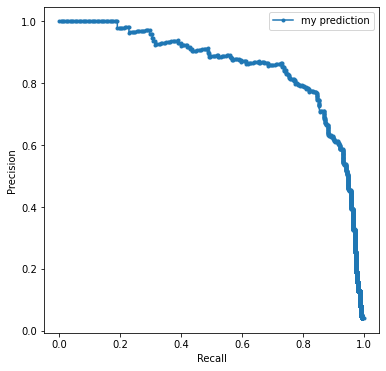

Training completed...


In [15]:
print(f'Training WaveNet model with {SPLITS} folds Started...')
run_cv_model_by_batch(train, test, SPLITS, features, sample_submission, EPOCHS, NNBATCHSIZE)
print('Training completed...')